In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
from pandas import set_option
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as md
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn
import statsmodels as stm
import patsy

In [2]:
data = pd.read_excel('almost_continuous.xlsx', index_col=0)
data.head()

,timeStamp,tripID,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos,deviceID
7000000,2017-12-06 18:08:11.000000,787,00a0fa200438011e3b011e3b011f3c011f3b021e3c021f...,0.9,0,0,0,0.000000,0,0,0.000000,0.00,0.00,0,0,0.0,53
7000001,2017-12-06 18:08:12.000000,787,0068fa100328011e3c011f3c001e3b011f3b011f3c011f...,0.9,0,0,0,0.000000,0,0,0.000000,0.00,0.00,0,0,0.0,53
7000002,2017-12-06 18:08:13.000000,787,00a0fa200488021e3c011e3a011e3a011f3b021f3c001f...,1.0,0,0,0,0.000000,0,0,0.000000,0.00,0.00,0,0,0.0,53
7000003,2017-12-06 18:36:33.000000,788,0158fa1004e0011c3b011d390000000000000000000000...,11.2,0,48,0,49.019608,30,95,0.954000,9.50,869.25,3,0,0.0,53
7000004,2017-12-06 18:36:34.000000,788,0130fa080498002531ff1f37001e37001e38011d3a051f...,14.1,0,48,0,48.235294,30,95,0.315016,9.59,869.75,1,0,0.0,53


In [3]:
data.describe()

,tripID,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos,deviceID
count,214695.000000,214695.000000,214695.0,214695.000000,214695.0,214695.000000,214695.000000,214695.000000,214695.000000,214695.000000,214695.000000,214695.000000,214695.0,214695.000000,214695.0
mean,928.761681,10.715801,0.0,64.770963,0.0,28.761401,25.899131,84.098931,3.725394,10.790695,936.428561,18.556958,0.0,7.267455,53.0
std,84.508427,11.833212,0.0,33.977269,0.0,26.839685,14.046318,41.567835,3.489355,7.487505,552.828065,21.064298,0.0,13.805778,0.0
min,787.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,53.0
25%,860.000000,0.000000,0.0,51.000000,0.0,0.000000,21.000000,95.000000,0.000000,8.560000,843.250000,0.000000,0.0,0.000000,53.0
50%,930.000000,8.200000,0.0,81.000000,0.0,27.843137,29.000000,97.000000,3.950538,9.650000,907.000000,14.000000,0.0,0.000000,53.0
75%,998.000000,17.000000,0.0,91.000000,0.0,43.921569,35.000000,101.000000,6.395641,14.530000,1323.250000,30.000000,0.0,9.411765,53.0
max,1081.000000,102.780000,0.0,97.000000,0.0,99.607843,58.000000,236.000000,26.477155,68.280000,2826.250000,135.000000,0.0,99.607843,53.0


In [4]:
def feature_subplots(df, title):
    df.plot(subplots=True, layout=(20,1),lw= 1.6,figsize=(16, 24),sharex=True, title=title)

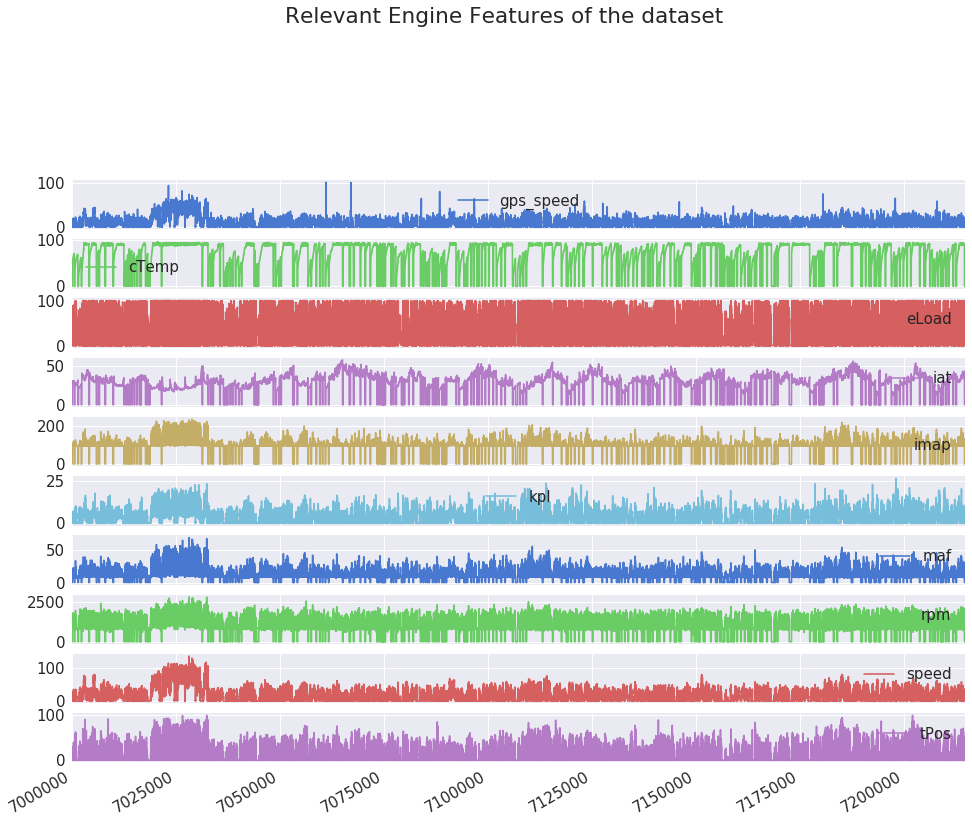

In [5]:
feature_subplots(data.drop(['dtc','battery','tAdv','tripID','timeStamp','accData','deviceID'],axis=1),'Relevant Engine Features of the dataset')
#plt.savefig('train.png', format = 'png', dpi=300)

# Mining Time Series Data

## 1. Handling missing values

In [6]:
data = data.replace(0.0, np.nan)
data.gps_speed = data.gps_speed.interpolate(); data.cTemp=data.cTemp.interpolate(); data.eLoad=data.eLoad.interpolate();
data['iat']=data['iat'].interpolate();data.imap=data.imap.interpolate();data.kpl=data.kpl.interpolate();
data.maf=data.maf.interpolate();data.rpm=data.rpm.interpolate();
data.speed=data.speed.interpolate();data.tPos=data.tPos.interpolate();

In [7]:
data = data.reset_index()

## 2. Noise removal

In [8]:
from fecon235.fecon235 import *
grids = 2 
def holt_features(df,grids):
    alpha = 0; beta = 0; losspc = 0; loss = 0;
    alpha, beta, losspc, loss = optimize_holt(df, grids=grids, alphas=(0.0, 1.0), betas=(0.0, 1.0))
    holtdf = holt(df, alpha=alpha, beta=beta)
    return(holtdf)

In [9]:
print(data.columns.values)
#data = data.drop(['level_0'], axis = 1)

['index' 'timeStamp' 'tripID' 'accData' 'gps_speed' 'battery' 'cTemp' 'dtc'
 'eLoad' 'iat' 'imap' 'kpl' 'maf' 'rpm' 'speed' 'tAdv' 'tPos' 'deviceID']


In [10]:
go_gps_speed = data.drop(['index','timeStamp','tripID','accData','cTemp','battery','eLoad','dtc','iat','imap',
                         'kpl','maf','rpm','speed','tAdv','tPos','deviceID'],axis = 1)
holt_gps_speed = holt_features(go_gps_speed,grids)

go_cTemp = data.drop(['index','timeStamp','tripID','accData','gps_speed','battery','eLoad','dtc','iat','imap',
                         'kpl','maf','rpm','speed','tAdv','tPos','deviceID'],axis = 1)
holt_cTemp = holt_features(go_cTemp,grids)

go_eLoad = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','dtc','iat','imap',
                         'kpl','maf','rpm','speed','tAdv','tPos','deviceID'],axis = 1)
holt_eLoad = holt_features(go_eLoad,grids)

go_iat = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','eLoad','dtc','imap',
                         'kpl','maf','rpm','speed','tAdv','tPos','deviceID'],axis = 1)
holt_iat = holt_features(go_iat,grids)

go_imap = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','eLoad','dtc','iat',
                         'kpl','maf','rpm','speed','tAdv','tPos','deviceID'],axis = 1)
holt_imap = holt_features(go_imap,grids)

go_rpm = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','eLoad','dtc','iat','imap',
                         'kpl','maf','speed','tAdv','tPos','deviceID'],axis = 1)
holt_rpm = holt_features(go_rpm,grids)

go_speed = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','eLoad','dtc','iat','imap',
                         'kpl','maf','rpm','tAdv','tPos','deviceID'],axis = 1)
holt_speed = holt_features(go_speed,grids)

go_maf = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','eLoad','dtc','iat','imap',
                         'kpl','maf','rpm','tAdv','tPos','deviceID'],axis = 1)
holt_maf = holt_features(go_maf,grids)

go_tPos = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','eLoad','dtc','iat','imap',
                         'kpl','maf','rpm','tAdv','tPos','deviceID'],axis = 1)
holt_tPos = holt_features(go_tPos,grids)

go_kpl = data.drop(['index','timeStamp','tripID','accData','gps_speed','cTemp','battery','eLoad','dtc','iat','imap',
                         'maf','rpm','tAdv','tPos','deviceID','speed'],axis = 1)
holt_kpl = holt_features(go_kpl,grids)

In [11]:
df = pd.DataFrame()
df = pd.concat([holt_gps_speed['Y'],holt_cTemp['Y'],holt_eLoad['Y'],holt_iat['Y'],holt_imap['Y'],holt_rpm['Y'],
                         holt_speed['Y'],holt_maf['Y'],holt_tPos['Y'],holt_kpl['Y']],axis = 1)
df = df.values
df = pd.DataFrame(df)
df = df.rename(columns={0:'gps_speed',1:'cTemp',2:'eLoad',3:'iat',4:'imap',5:'rpm',6:'speed',7:'maf',8:'tPos',9:'kpl'})

In [12]:
def feature_subplots(df, title):
    df.plot(subplots=True, layout=(20,1),lw= 1.6,figsize=(16, 24),sharex=True, title=title)

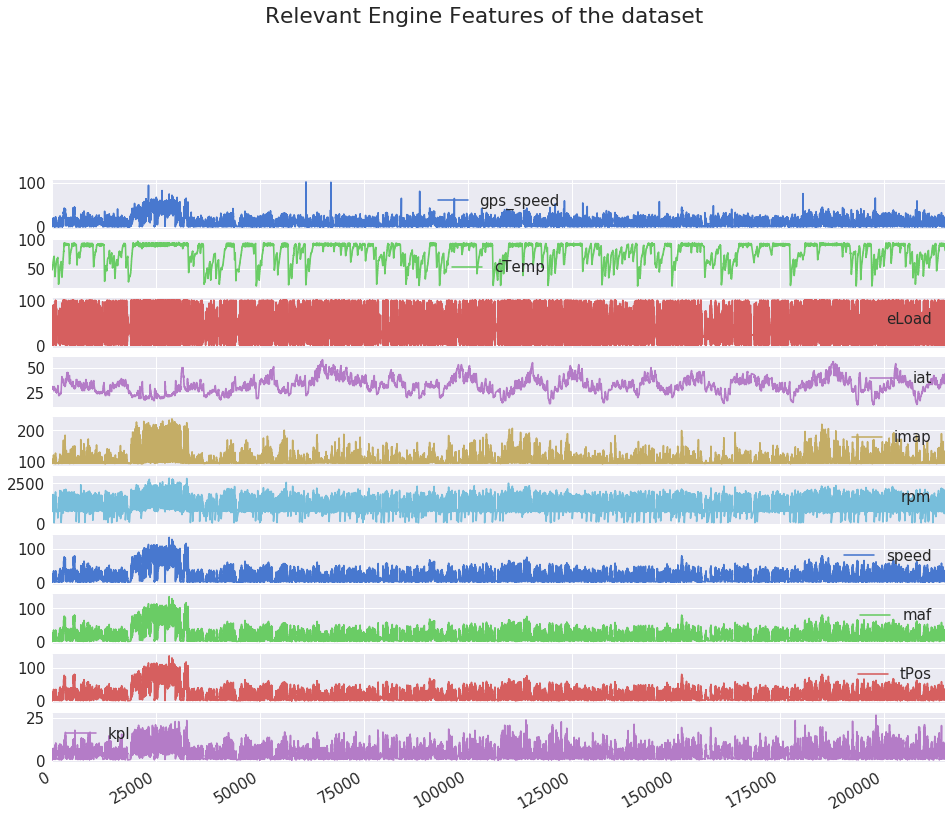

In [13]:
feature_subplots(df,'Relevant Engine Features of the dataset')
#plt.savefig('train.png', format = 'png', dpi=300)

In [15]:
set_option('display.max_rows',10)
df = df[3::]
df

,gps_speed,cTemp,eLoad,iat,imap,rpm,speed,maf,tPos,kpl
3,11.2,48.000000,49.019608,30.000000,95.0,869.25000,3.000000,3.000000,3.000000,0.954000
4,14.1,48.000000,48.235294,30.000000,95.0,869.75000,1.000000,1.000000,1.000000,0.315016
5,14.7,48.000000,48.235294,30.000000,94.0,866.50000,1.044444,1.044444,1.044444,0.329441
6,14.9,49.000000,49.411765,30.000000,95.0,864.00000,1.088889,1.088889,1.088889,0.343866
7,15.4,49.000000,47.450980,30.000000,95.0,869.50000,1.133333,1.133333,1.133333,0.358291
...,...,...,...,...,...,...,...,...,...,...
214690,1.8,81.266667,30.831416,43.903614,95.0,913.86236,3.000000,3.000000,3.000000,1.047746
214691,1.8,81.200000,30.868660,43.927711,95.0,915.45927,3.000000,3.000000,3.000000,1.047746
214692,1.8,81.133333,30.905904,43.951807,95.0,917.05618,3.000000,3.000000,3.000000,1.047746
214693,1.8,81.066667,30.943148,43.975904,95.0,918.65309,3.000000,3.000000,3.000000,1.047746


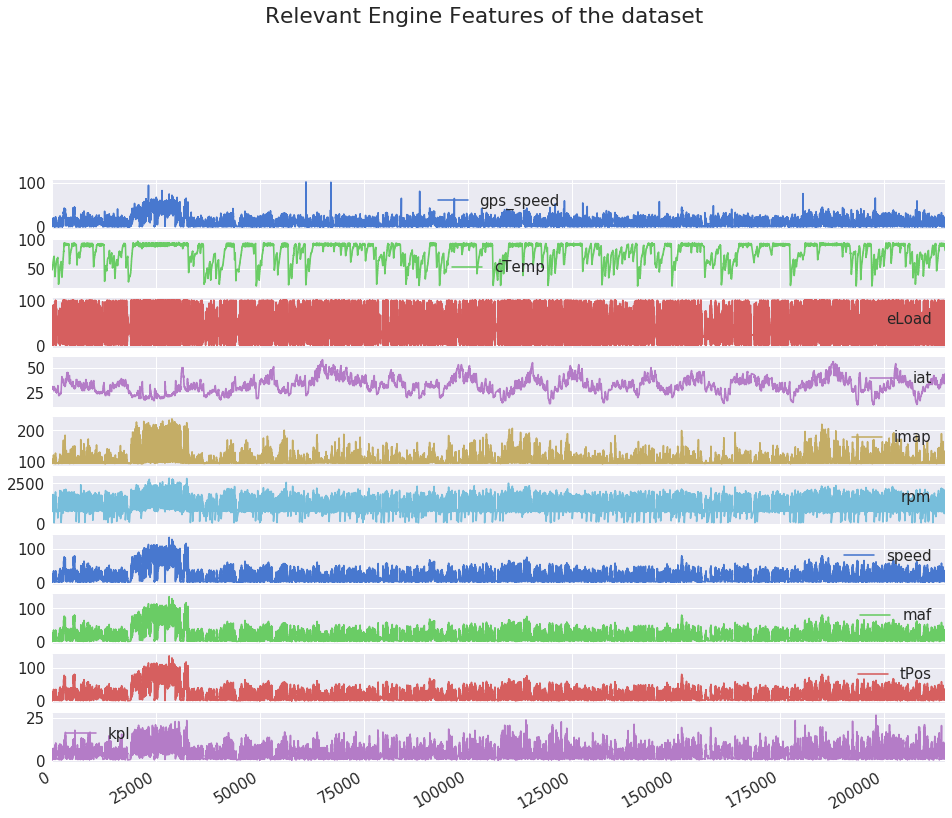

In [16]:
feature_subplots(df,'Relevant Engine Features of the dataset')


In [17]:
df.columns

Index(['gps_speed', 'cTemp', 'eLoad', 'iat', 'imap', 'rpm', 'speed', 'maf',
       'tPos', 'kpl'],
      dtype='object')

## 3. Normalization

In [19]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(values)
df = pd.DataFrame(scaled_df, columns=['gps_speed', 'cTemp', 'eLoad', 'iat', 'imap', 'rpm', 'speed', 'maf','tPos', 'kpl'])

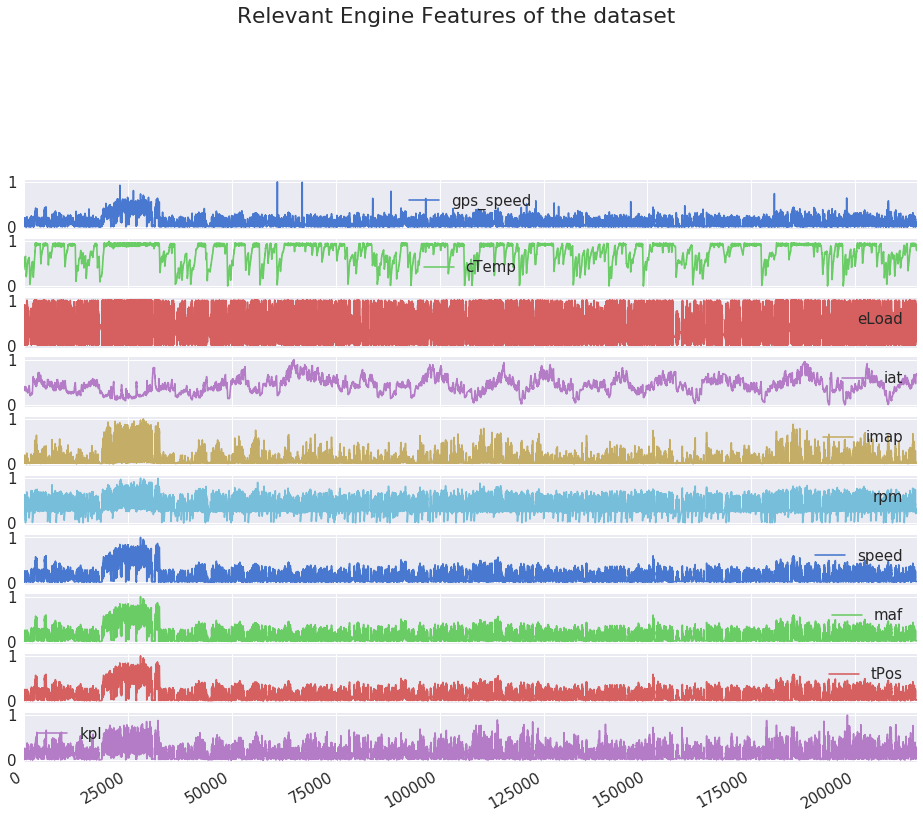

In [20]:
feature_subplots(df,'Relevant Engine Features of the dataset')

In [21]:
writer = pd.ExcelWriter('data_prepared_almost_continuous.xlsx')
df.to_excel(writer, 'Sheet1')
writer.save()

df.to_csv('data_prepared_almost_continuous.csv')